<a href="https://colab.research.google.com/github/tiborvansa/3d_armor_flyswim/blob/main/AirPump_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AirPump failures
Author: Tibor Vansa

Task: Create basic EDA + baseline prediction of air pump failures


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = '/content/drive/MyDrive/datamole/'

In [ ]:
#load data with target variable PumpFailed
labels = pd.read_csv(DATA_PATH + 'labels.csv')
labels.info()
labels.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN


In [ ]:
#suprisingly,  even the traget variable has missing values. They are limited to rows with missing value for MeasurementId. Maybe there could also be some applicable
#information, but for now we drop them
print(labels[labels['PumpFailed'].isnull()].groupby('MeasurementId').count())
labels.dropna(subset=['PumpFailed'],inplace=True)
print(labels.shape)

               MachineId  PumpFailed  SlowStart  SlowEnd
MeasurementId                                           
-1                   485           0          0        0
(26900, 5)


In [ ]:
#the dataset is imbalanced
labels.groupby(['PumpFailed']).size()

PumpFailed
False    23958
True      2942
dtype: int64

In [ ]:
#check for missing values in other columns
labels.isnull().sum()

MachineId           0
MeasurementId       0
PumpFailed          0
SlowStart        7600
SlowEnd          7600
dtype: int64

In [ ]:
#see the failure rate by provided labels
labels['Failed']=labels['PumpFailed'].astype(int)
labels[['SlowStart','SlowEnd']]=labels[['SlowStart','SlowEnd']].fillna('NaN')
pd.pivot_table(labels, values='Failed',
                                index=['SlowStart'],
                                columns=['SlowEnd'],
                                aggfunc=[np.mean,np.sum,len],
                                margins = True
                                )


mean                                   sum                    \
SlowEnd       False      True       NaN       All   False True    NaN   All   
SlowStart                                                                     
False      0.149581  0.000523       NaN  0.118363  2158.0  2.0    NaN  2160   
True       0.000000  0.000000       NaN  0.000000     0.0  0.0    NaN     0   
NaN             NaN       NaN  0.102895  0.102895     NaN  NaN  782.0   782   
All        0.139433  0.000523  0.102895  0.109368  2158.0  2.0  782.0  2942   

               len                         
SlowEnd      False    True     NaN    All  
SlowStart                                  
False      14427.0  3822.0     NaN  18249  
True        1050.0     1.0     NaN   1051  
NaN            NaN     NaN  7600.0   7600  
All        15477.0  3823.0  7600.0  26900

In [ ]:
#The almost no failure rate for cases with either slow star or slow end is a bit confusing.
#I have excepted that slow start or end will be an indication of higher probability of failure.
#The only explanation I could imagine now is that the some records where more closly inspected by human expert based on e.g. lower median presure,
#and instead of labeling them as a failure, they were labeles as just slow start/end
#Therefore is a question, if they should be included into predictive model as predictors,
#because the purpose of the model is to replace the need of such human intervention

In [ ]:
#one hot encode for easier future use
labelsD = pd.get_dummies(labels,columns=['SlowStart','SlowEnd'],drop_first=True)
print(labelsD.head())

  MachineId  MeasurementId PumpFailed  Failed  SlowStart_True  SlowStart_NaN  \
0     0_0_0              0      False       0               0              0   
2     0_0_2              0      False       0               0              0   
3     0_0_3              0       True       1               0              0   
5     0_1_1              1       True       1               0              0   
8     1_0_0              2      False       0               1              0   

   SlowEnd_True  SlowEnd_NaN  
0             0            0  
2             0            0  
3             0            0  
5             0            0  
8             0            0  


374


<Axes: >

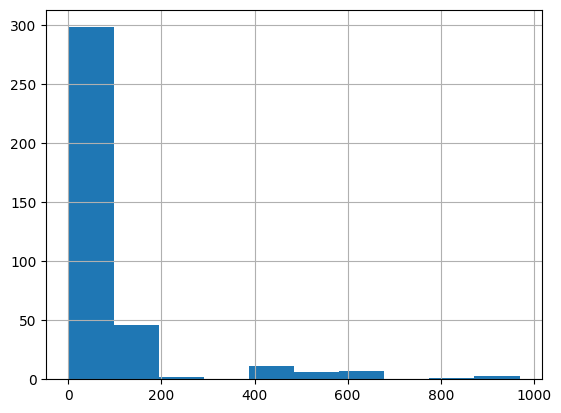

In [ ]:
#look on the number of machines and distribution of number of cycles
machines = labels.groupby('MachineId').size()
print(len(machines))
machines.hist()

In [ ]:
#check for duplicates - none, good
labels[labels.duplicated(subset=['MachineId','MeasurementId'])]

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,Failed


In [ ]:
#now read time series data
data = pd.read_parquet(DATA_PATH + 'data.parquet')
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [ ]:
#restrict them only on machines and cycles with provided labels
data.set_index(['MachineId','MeasurementId'],inplace=True)
labels.set_index(['MachineId','MeasurementId'],inplace=True)
labelsD.set_index(['MachineId','MeasurementId'],inplace=True)
data = data.loc[labels.index]
data['time'] = data.groupby(['MachineId','MeasurementId']).cumcount() + 1
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13195033 entries, ('0_0_0', 0) to ('10_0_3', 8834)
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Pressure  float64
 1   time      int64  
dtypes: float64(1), int64(1)
memory usage: 252.0+ MB


In [ ]:
#check for missing values
data.isnull().any()

Pressure    False
time        False
dtype: bool

<ipython-input-18-604700f6876d>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[labels.index[0],:]


<Axes: xlabel='time'>

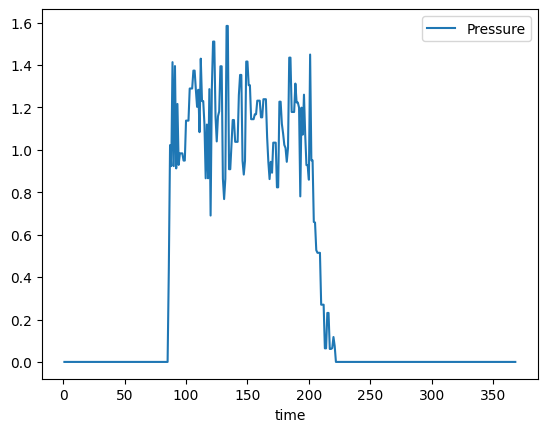

In [ ]:
#plot some example
record = data.loc[labels.index[0],:]
record.plot(x='time',y='Pressure')

In [ ]:
#there are a lot of zeros, we could significantly reduce data size by removing them
#and only storing the index of first and last nonzero value
orig_lenght = data.groupby(level=[0,1]).size()
first_nonzero_index = data.groupby(level=[0,1])['Pressure'].apply(lambda x: x.to_numpy().nonzero()[0][0] if (x != 0).any() else len(x))
last_nonzero_index = data.groupby(level=[0,1])['Pressure'].apply(lambda x: len(x) - np.argwhere(x.to_numpy()[::-1]>0)[0][0] if (x != 0).any() else 0)
res_data = data.groupby(level=[0,1]).apply(lambda x: x.iloc[first_nonzero_index[x.name]:last_nonzero_index[x.name]])
res_data = res_data.droplevel([0,1])
new_lenght = res_data.groupby(level=[0,1]).size()

26900 13195033
26838 5531640


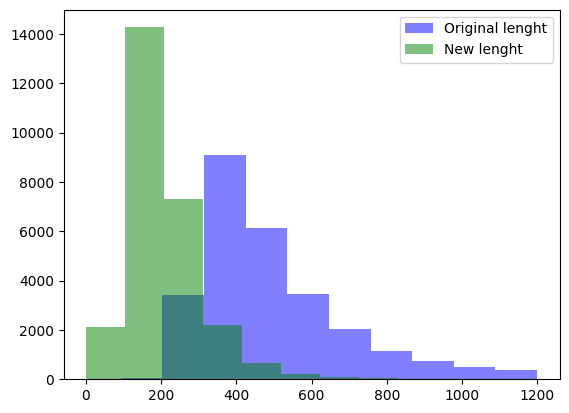

In [ ]:
#compare lenght of original data and new one. The shortest records should be further inspected, if they contain meaningfull information
#note that some records contain only zeros
print(len(orig_lenght),len(data))
print(len(new_lenght),len(res_data))
plt.hist(orig_lenght, alpha=0.5, label='Original lenght', color='blue')
plt.hist(new_lenght, alpha=0.5, label='New lenght', color='green')
plt.legend()
plt.show()

PumpFailed    False
SlowStart     False
SlowEnd       False
Failed            0
Name: (0_0_2, 3188), dtype: object


<ipython-input-21-259692796330>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[machId,:]


                         Pressure  time
MachineId MeasurementId                
0_0_2     3188           0.186957    85
          3188           0.186957    86
          3188           0.186957    87
          3188           0.142391    88
          3188           0.142391    89
          3188           0.069565    90
          3188           0.069565    91
          3188           0.082609    92
          3188           0.255435    93


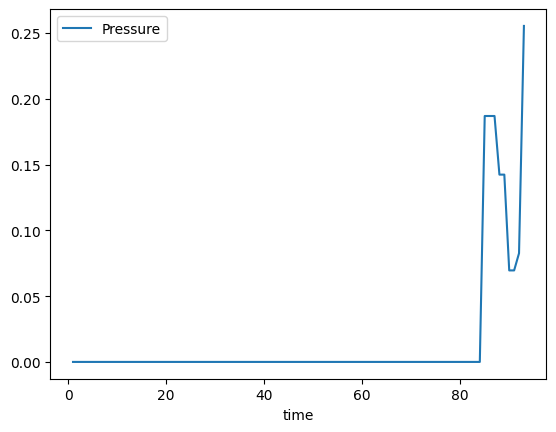

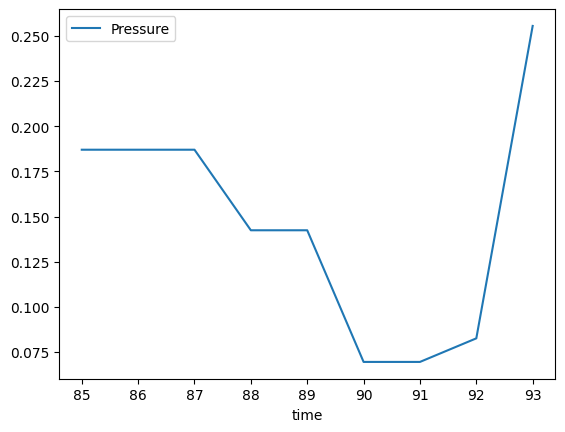

In [ ]:
#lets inspect some outliers with very few nonzero values
#it seems that even records with less than 10 nonzero values are labelad as non failed
#why records where the machine practically did not start working at all are labeled as OK?
#the first example seems to censored from the right - I do not seem expected end of cycle. So the middle period, which should be tested for failure,
#is maybe not captured in data
#usually i will send a question to the domain expert, if such cases are representative enouhgt and should be included in development sample
machId = new_lenght[new_lenght<10].index[0]
print(labels.loc[machId,:])
record = data.loc[machId,:]
record.plot(x='time',y='Pressure')
record2 = res_data.loc[machId,:]
record2.plot(x='time',y='Pressure')
print(record[record['Pressure']>0].head(10))

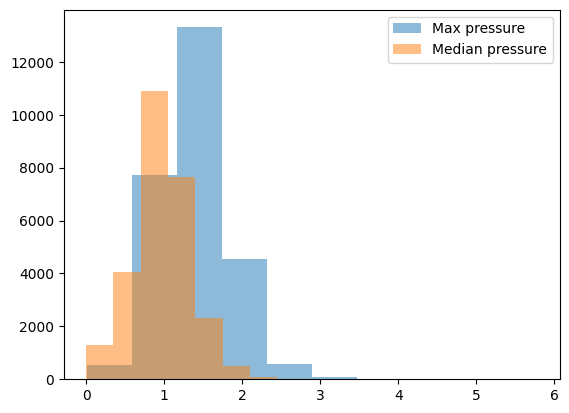

In [ ]:
#distribution of maximum pressure
max_pressure = res_data.groupby(level=[0,1])['Pressure'].max()
median_pressure = res_data.groupby(level=[0,1])['Pressure'].median()
plt.hist(max_pressure, alpha=0.5, label='Max pressure')
plt.hist(median_pressure, alpha=0.5, label='Median pressure')
plt.legend()
plt.show()


In [ ]:
#lets look of there is a connection between very short records and low max pressure
basic_features  = pd.concat([orig_lenght, new_lenght, first_nonzero_index, last_nonzero_index,max_pressure, median_pressure]
                            , axis = 1,keys=['orig_lenght', 'new_lenght', 'first_nonzero_index', 'last_nonzero_index', 'max_press','median_press'])
basic_features.fillna(0,inplace=True)
basic_features = labelsD.merge(basic_features,left_index=True, right_index=True)
failed = basic_features[basic_features['Failed']==1]
nonfailed = basic_features[basic_features['Failed']==0]

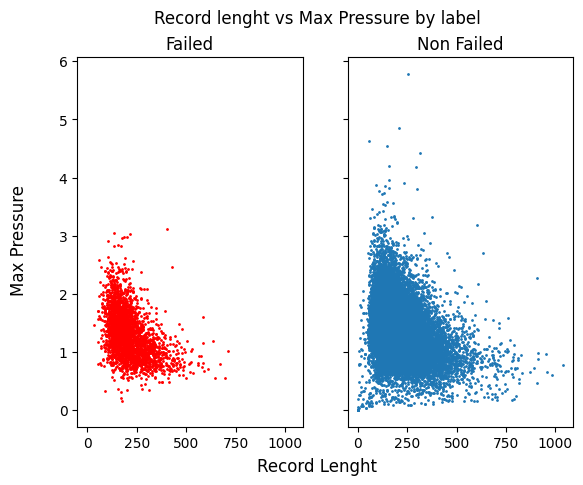

In [ ]:
#I see several outliers
fig, (ax1, ax2) = plt.subplots(1, 2,  sharex=True, sharey=True)
fig.suptitle('Record lenght vs Max Pressure by label')
fig.supxlabel("Record Lenght")
fig.supylabel("Max Pressure")
ax1.title.set_text('Failed')
ax1.scatter(failed.new_lenght,failed.max_press,s=1,color='red')
ax2.title.set_text('Non Failed')
ax2.scatter(nonfailed.new_lenght,nonfailed.max_press,s=1)

<Axes: xlabel='time'>

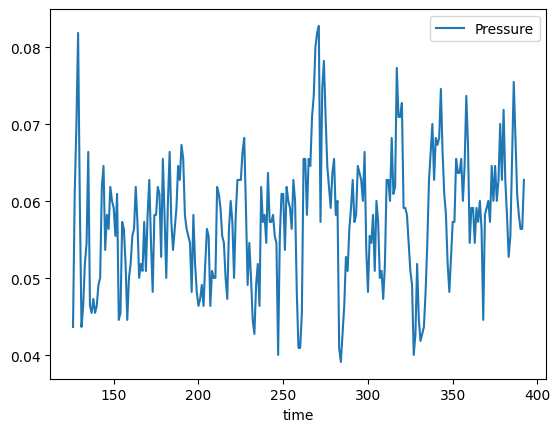

In [ ]:
#lets show some very low pressure example
machId = basic_features[basic_features['new_lenght']>250].sort_values(by='max_press').index[0]
record = res_data.loc[machId,:]
record.plot(x='time',y='Pressure')

In [ ]:
#lets show shortest failed case
machId = failed.sort_values(by='new_lenght').index[0]
record = res_data.loc[machId,:]
record.plot(x='time',y='Pressure')

KeyError: ignored

(array([ 13.,  10.,  11.,  12.,   8., 117., 160., 313., 421., 673.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

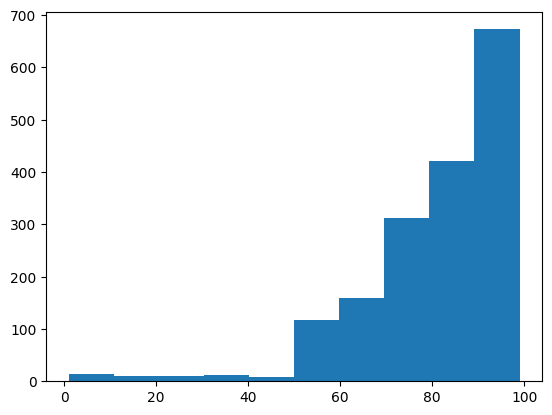

In [ ]:
#zoom a bit to short case. Based on these figures, i would not recomend usage of the model on records with less than 50 nonzero lenght
plt.hist(new_lenght[new_lenght<100])

In [ ]:
#for now, I do not have idea, if the pressure in these short spikes are

In [ ]:
#let plot few examples of each type
good = labelsD[(labelsD['Failed']==0) & (labelsD['SlowStart_True']==0) & (labelsD['SlowEnd_True']==0)]
failed = labelsD[(labelsD['Failed']==1)]
slow_start = labelsD[(labelsD['Failed']==0) & (labelsD['SlowStart_True']==1) & (labelsD['SlowEnd_True']==0)]
slow_end = labelsD[(labelsD['Failed']==0) & (labelsD['SlowStart_True']==0) & (labelsD['SlowEnd_True']==1)]
slow_both = labelsD[(labelsD['Failed']==0) & (labelsD['SlowStart_True']==1) & (labelsD['SlowEnd_True']==1)]
good.shape

(19087, 6)

<ipython-input-30-ab4fdf3f1a01>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[failed.index[i],:]
<ipython-input-30-ab4fdf3f1a01>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[failed.index[i],:]
<ipython-input-30-ab4fdf3f1a01>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[failed.index[i],:]
<ipython-input-30-ab4fdf3f1a01>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[failed.index[i],:]
<ipython-input-30-ab4fdf3f1a01>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[failed.index[i],:]


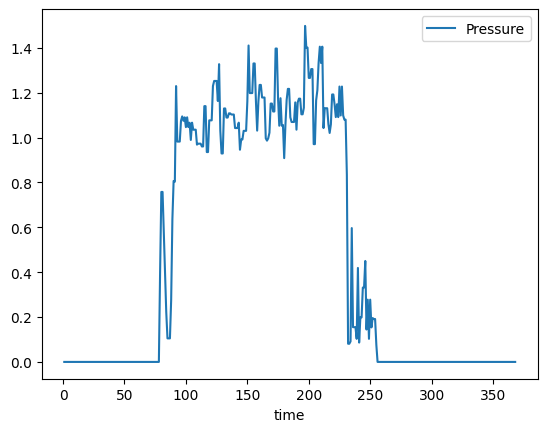

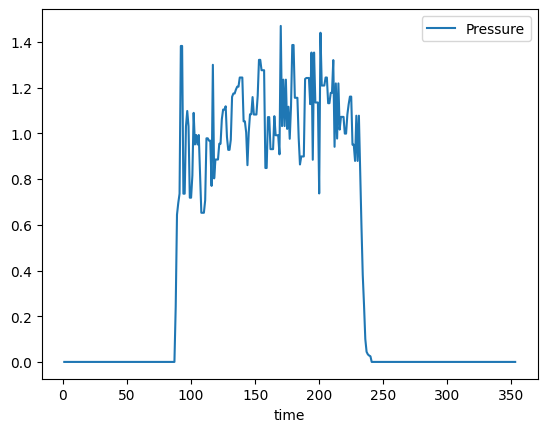

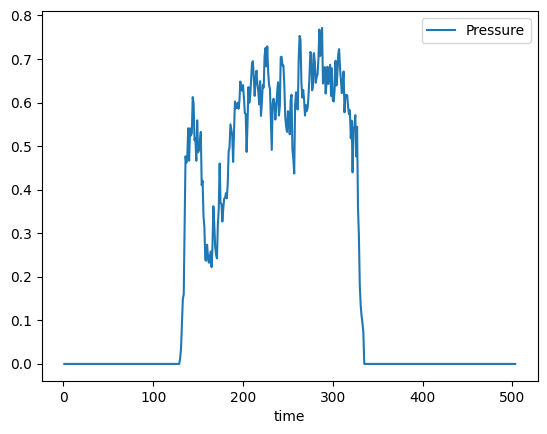

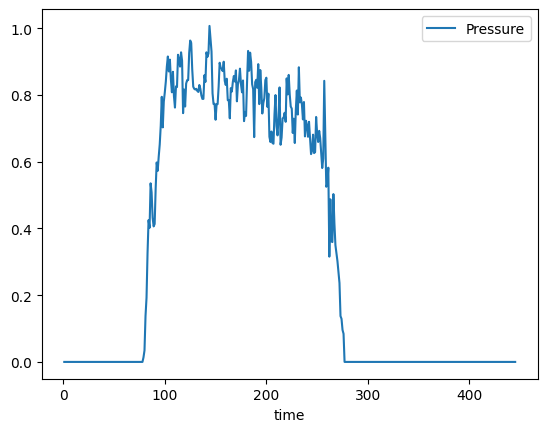

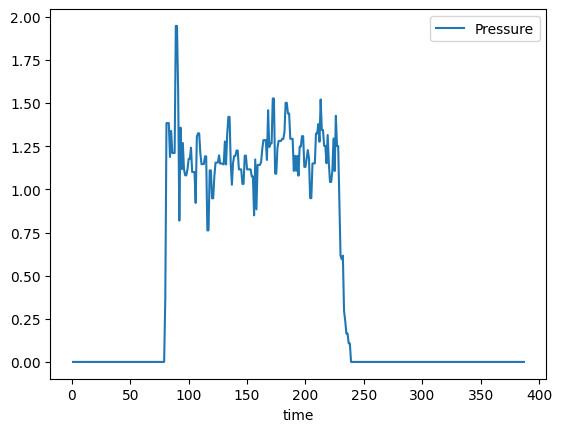

In [ ]:
for i in range(5):
  record = data.loc[failed.index[i],:]
  record.plot(x='time',y='Pressure')

<ipython-input-31-cf3909e6238c>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_start.index[i],:]
<ipython-input-31-cf3909e6238c>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_start.index[i],:]
<ipython-input-31-cf3909e6238c>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_start.index[i],:]
<ipython-input-31-cf3909e6238c>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_start.index[i],:]
<ipython-input-31-cf3909e6238c>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_start.index[i],:]


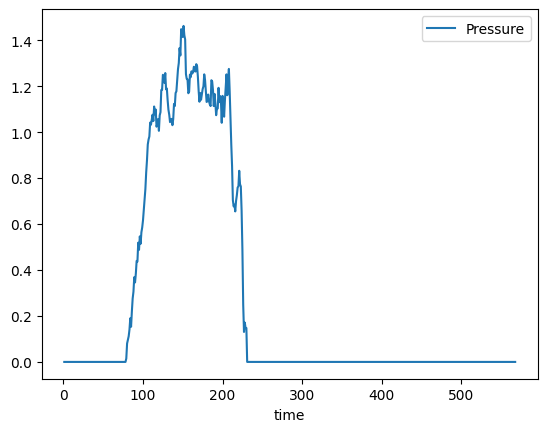

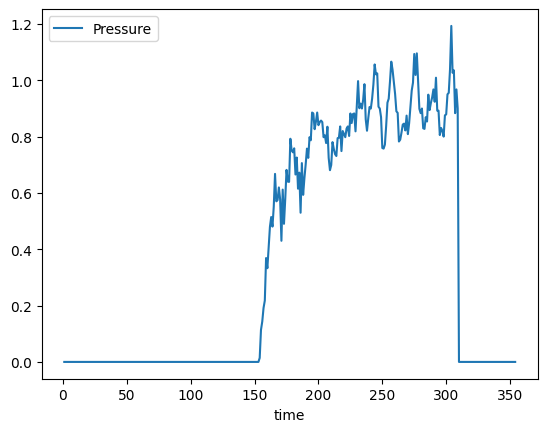

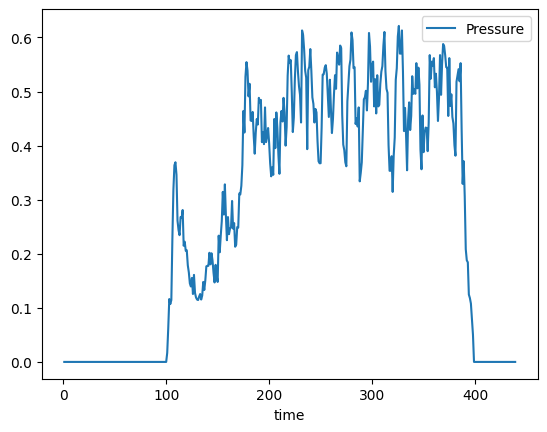

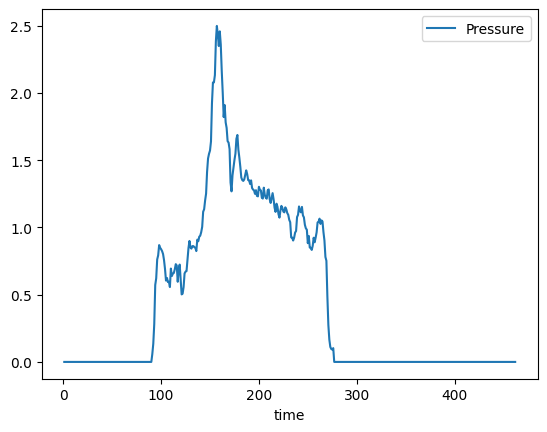

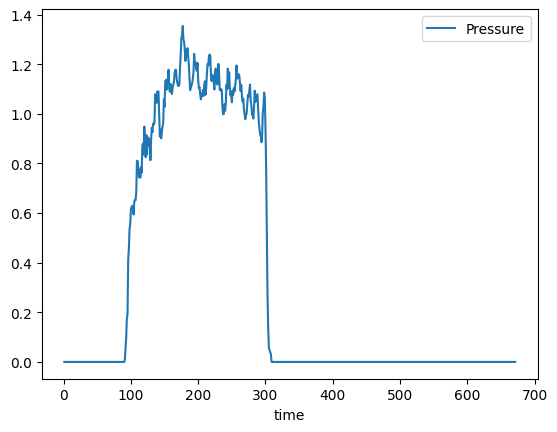

In [ ]:
for i in range(5):
  record = data.loc[slow_start.index[i],:]
  record.plot(x='time',y='Pressure')

<ipython-input-32-2b503b3e2ef3>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_end.index[i],:]
<ipython-input-32-2b503b3e2ef3>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_end.index[i],:]
<ipython-input-32-2b503b3e2ef3>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[slow_end.index[i],:]


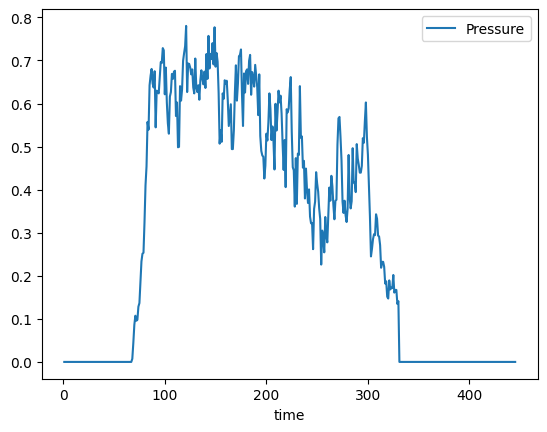

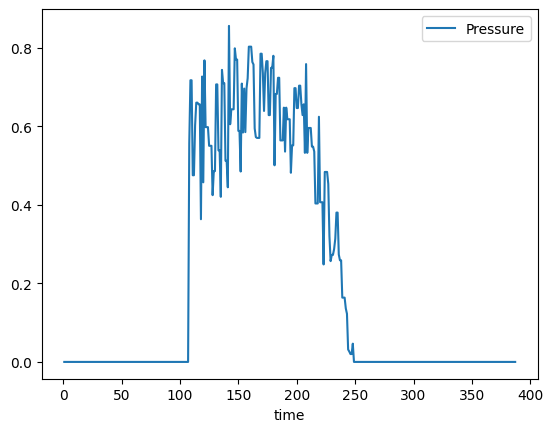

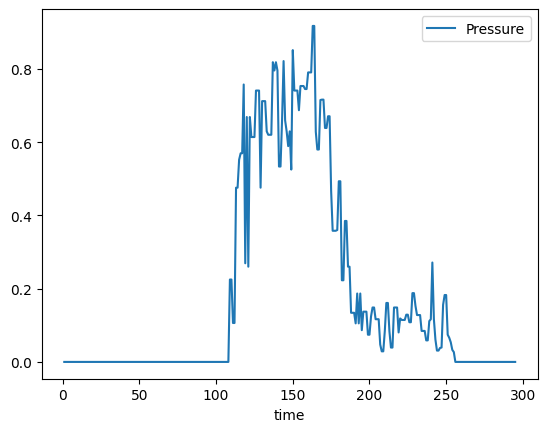

In [ ]:
for i in range(3):
  record = data.loc[slow_end.index[i],:]
  record.plot(x='time',y='Pressure')

<ipython-input-33-c58cea696938>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[good.index[i],:]
<ipython-input-33-c58cea696938>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[good.index[i],:]
<ipython-input-33-c58cea696938>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  record = data.loc[good.index[i],:]


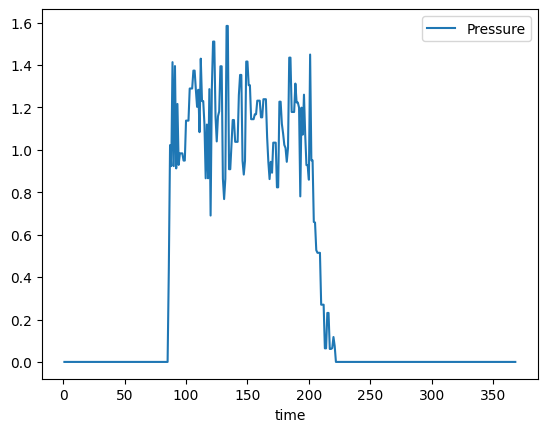

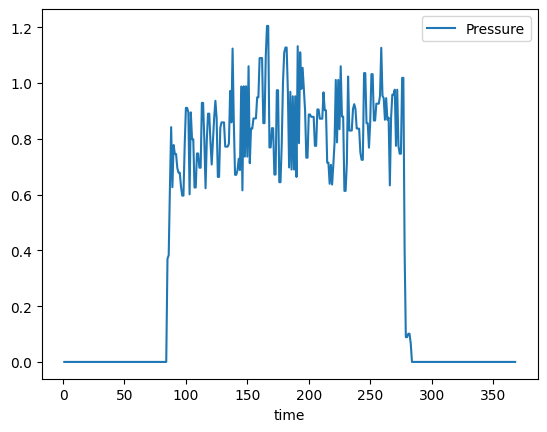

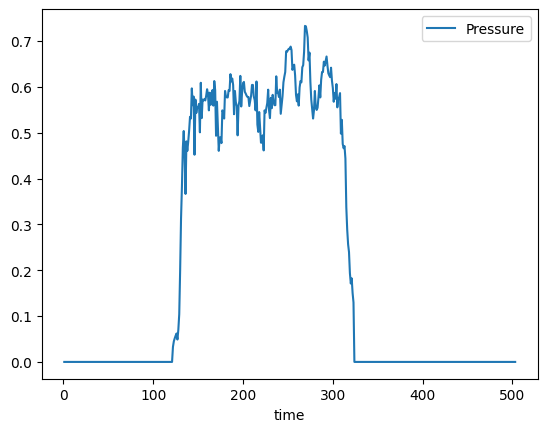

In [ ]:
for i in range(3):
  record = data.loc[good.index[i],:]
  record.plot(x='time',y='Pressure')

# Feature engineering

In [ ]:
#scaling the pressure values between 0 and 1, it usually help a ML a lot
#I have already stored the not-normalized values of pressure for later use in modelling, so I am not losing any information
#I do not use StandardScaler, because I think it is useful to preserve the relation to zero pressure, I just want to have same max pressure in all cases
#I do not use from sklearn.preprocessing import MinMaxScaler, because I drop the zero values, whitch



In [ ]:
#domain expert knowledge:
#Ideally, the air pressure rises sharply and remains stable throughout the machine's cycle, where it drops sharply
#The typical air pump failure is a temporary pressure decrease in the first half of the cycle.

#So I want to heuristically divide each record into 3 part: start, middle, end and calculate some basic stats for each of them

In [ ]:
def calc_features(window):
  '''For given series, estimate basic statistical functions and 3 measures of big drop downs of values'''
  features = []
  #basic features
  features.append(len(window))
  features.append(window.min())
  features.append(window.max())
  features.append(window.mean())
  features.append(window.median())
  features.append(window.var())
  #here I try to capture the size of potential drop in pressure
  features.append(sum(window[window < window.median() - window.std()]))
  features.append(len(window[window < window.median() - window.std()]))
  features.append(window.pct_change().min())
  return features

In [ ]:
def record_features(record):
  '''Divede record into three windows - until the machine first time reach full pressure, middle part, phase out
     For each window calculate same features '''
  #scale
  record = record/record.max()
  #as an estimate for full pressure I use median
  median = record.median()
  first_over_median =  np.argwhere(record.to_numpy()>=median)[0][0]
  last_over_median =  len(record) - np.argwhere(record.to_numpy()[::-1]>=median)[0][0]

  #there always have to be some start and end, with min lenght 10
  l = len(record)
  first_over_median = min(max(first_over_median,10),l-10)
  last_over_median = max(min(last_over_median,l-10),11)

  #ensure there is also always a middle part
  if last_over_median < first_over_median + 10:
    last_over_median = first_over_median + 10

  try:
    start_w = record[0:first_over_median]
    middle_w = record[first_over_median:last_over_median]
    end_w = record[last_over_median:]
  except Exception as e:
    raise ValueError(f"My error: {first_over_median,last_over_median}")

  out_features = []
  out_features.extend(calc_features(start_w))
  out_features.extend(calc_features(middle_w))
  out_features.extend(calc_features(end_w))

  feature_names = []
  fl = ['len','min','max','mean','median','var','lenght_low_press','sum_low_press','top_drop']
  feature_names.extend(['sw_'+var for var in fl])
  feature_names.extend(['mw_'+var for var in fl])
  feature_names.extend(['ew_'+var for var in fl])

  return pd.Series(out_features ,index=feature_names)

sw_len                  14.000000
sw_min                   0.015476
sw_max                   0.701190
sw_mean                  0.443622
sw_median                0.601786
sw_var                   0.071104
sw_lenght_low_press      0.582143
sw_sum_low_press         5.000000
sw_top_drop             -0.137521
mw_len                 174.000000
mw_min                   0.288095
mw_max                   1.000000
mw_mean                  0.735345
mw_median                0.782738
mw_var                   0.028813
mw_lenght_low_press     14.903571
mw_sum_low_press        34.000000
mw_top_drop             -0.239766
ew_len                  17.000000
ew_min                   0.092857
ew_max                   0.754762
ew_mean                  0.502941
ew_median                0.617857
ew_var                   0.064511
ew_lenght_low_press      0.766667
ew_sum_low_press         5.000000
ew_top_drop             -0.388199
dtype: float64


<Axes: xlabel='MachineId,MeasurementId'>

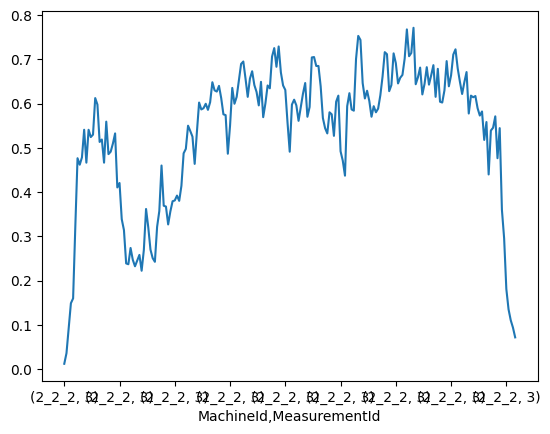

In [ ]:
#test my function
record = res_data.loc[failed.index[2],'Pressure']
print(record_features(record))
record.plot()

In [ ]:
#apply on records with lenght of at least 50
new_features = res_data.loc[basic_features[basic_features['new_lenght']>50].index,'Pressure'].groupby(level=[0,1]).apply(record_features).unstack()
new_features.head()

sw_len    sw_min    sw_max   sw_mean  sw_median  \
MachineId MeasurementId                                                    
0_0_0     0                10.0  0.277574  0.892157  0.641176   0.603554   
          215              17.0  0.185008  0.734716  0.541295   0.640617   
          237              10.0  0.561190  0.783033  0.630132   0.635787   
          353              10.0  0.181264  0.671744  0.495506   0.503427   
          411              18.0  0.069204  0.566321  0.276720   0.198962   

                           sw_var  sw_lenght_low_press  sw_sum_low_press  \
MachineId MeasurementId                                                    
0_0_0     0              0.031448             0.277574               1.0   
          215            0.042675             1.672515               6.0   
          237            0.004999             1.683569               3.0   
          353            0.015704             0.181264               1.0   
          411            0.035252             0.000000               0.0   

                         sw_top_drop  mw_len  ...  mw_top_drop  ew_len  \
MachineId MeasurementId                       ...                        
0_0_0     0                -0.346841   106.0  ...    -0.463396    20.0   
          215              -0.393841   149.0  ...    -0.403305    26.0   
          237              -0.151308   179.0  ...    -0.413692    34.0   
          353              -0.241497   195.0  ...    -0.469469    10.0   
          411              -0.628466   129.0  ...    -0.726862    24.0   

                           ew_min    ew_max   ew_mean  ew_median    ew_var  \
MachineId MeasurementId                                                      
0_0_0     0              0.038603  0.599877  0.223070   0.170343  0.033818   
          215            0.090909  0.778841  0.389298   0.388623  0.053256   
          237            0.020965  0.610434  0.220868   0.180644  0.024623   
          353            0.038842  0.732673  0.283549   0.210586  0.064882   
          411            0.069781  0.513264  0.193195   0.165225  0.016233   

                         ew_lenght_low_press  ew_sum_low_press  ew_top_drop  
MachineId MeasurementId                                                      
0_0_0     0                         0.000000               0.0    -0.762590  
          215                       0.721425               7.0    -0.644309  
          237                       0.042418               2.0    -0.686508  
          353                       0.000000               0.0    -0.748869  
          411                       0.000000               0.0    -0.478448  

[5 rows x 27 columns]

In [ ]:
print(new_features.isna().sum())

sw_len                 0
sw_min                 0
sw_max                 0
sw_mean                0
sw_median              0
sw_var                 0
sw_lenght_low_press    0
sw_sum_low_press       0
sw_top_drop            0
mw_len                 0
mw_min                 0
mw_max                 0
mw_mean                0
mw_median              0
mw_var                 0
mw_lenght_low_press    0
mw_sum_low_press       0
mw_top_drop            1
ew_len                 0
ew_min                 0
ew_max                 0
ew_mean                0
ew_median              0
ew_var                 0
ew_lenght_low_press    0
ew_sum_low_press       0
ew_top_drop            0
dtype: int64


In [ ]:
new_features[new_features == np.inf].count()

sw_len                 0
sw_min                 0
sw_max                 0
sw_mean                0
sw_median              0
sw_var                 0
sw_lenght_low_press    0
sw_sum_low_press       0
sw_top_drop            0
mw_len                 0
mw_min                 0
mw_max                 0
mw_mean                0
mw_median              0
mw_var                 0
mw_lenght_low_press    0
mw_sum_low_press       0
mw_top_drop            0
ew_len                 0
ew_min                 0
ew_max                 0
ew_mean                0
ew_median              0
ew_var                 0
ew_lenght_low_press    0
ew_sum_low_press       0
ew_top_drop            2
dtype: int64

In [ ]:
new_features[new_features['ew_top_drop']== np.inf]

,,sw_len,sw_min,sw_max,sw_mean,sw_median,sw_var,sw_lenght_low_press,sw_sum_low_press,sw_top_drop,mw_len,...,mw_top_drop,ew_len,ew_min,ew_max,ew_mean,ew_median,ew_var,ew_lenght_low_press,ew_sum_low_press,ew_top_drop
MachineId,MeasurementId,,,,,,,,,,,,,,,,,,,,,
0_1_3,7610,10.0,0.30546,0.876296,0.755771,0.784381,0.026370,0.30546,1.0,-0.010471,188.0,...,-0.369960,128.0,0.0,0.346925,0.002710,0.0,0.000940,0.0,0.0,inf
1_2_0,3770,10.0,0.01423,0.314360,0.175291,0.168823,0.006916,0.01423,1.0,-0.357843,112.0,...,-0.336397,87.0,0.0,0.016818,0.000193,0.0,0.000003,0.0,0.0,inf


In [ ]:
#it places inf values where there was not drop at at all, so replacing by 0 is OK
new_features.replace(np.inf, 0, inplace=True)
new_features.fillna(0,inplace=True)

In [ ]:
dev_sample = new_features.merge(basic_features,how='inner',left_index=True,right_index=True)

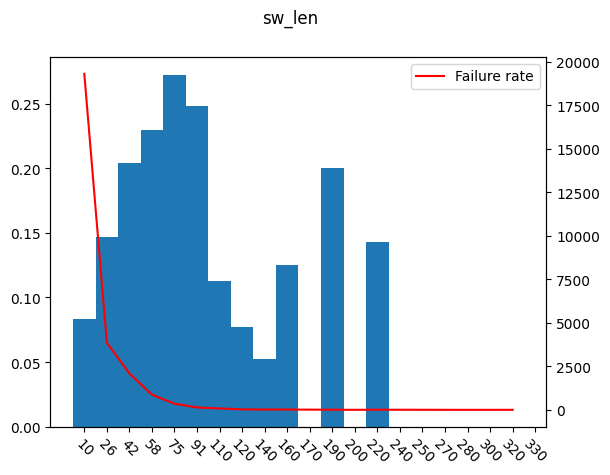

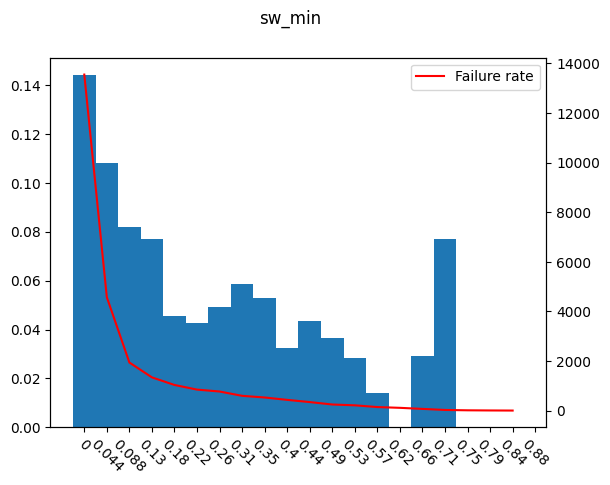

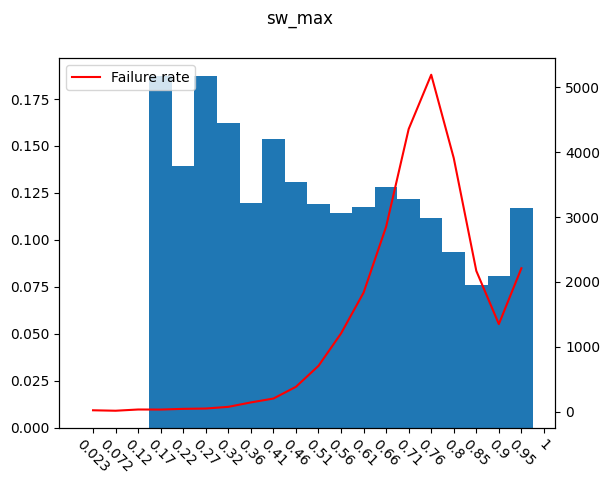

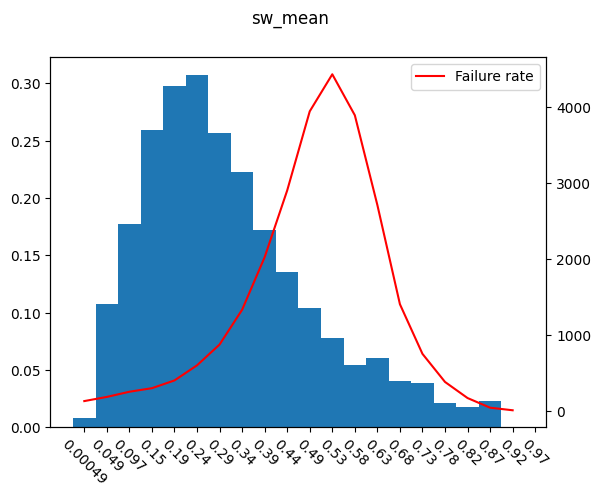

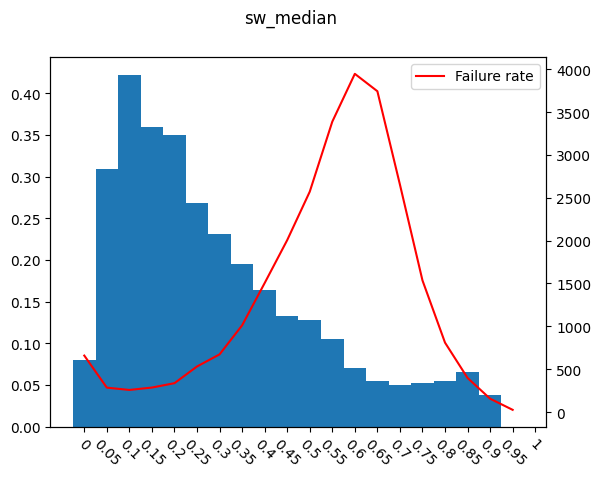

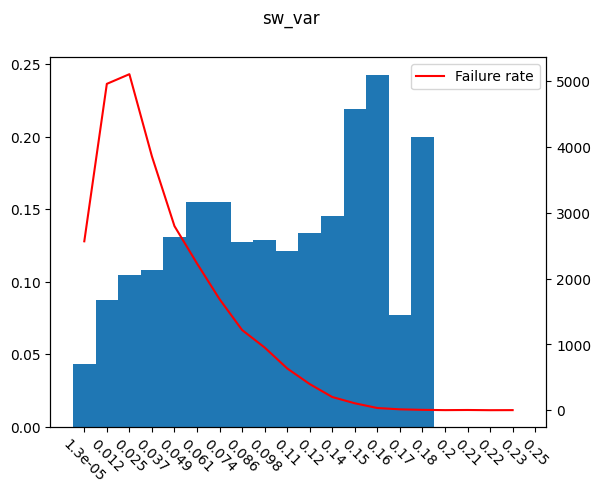

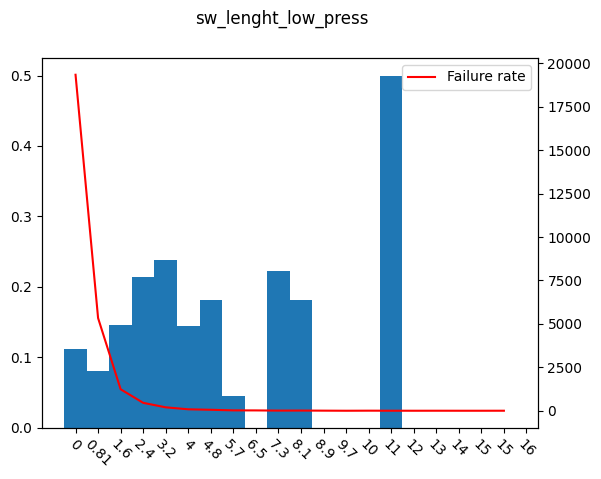

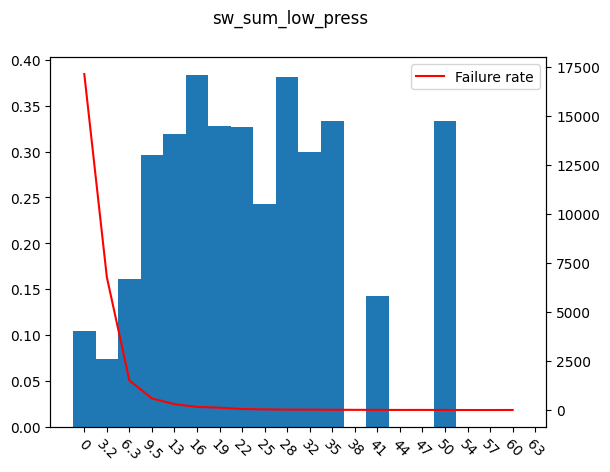

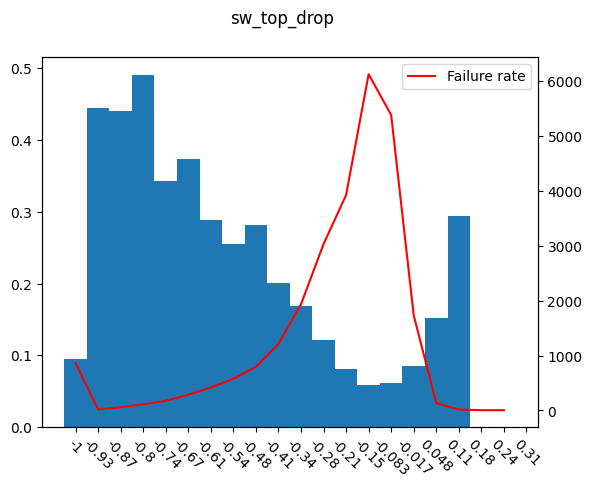

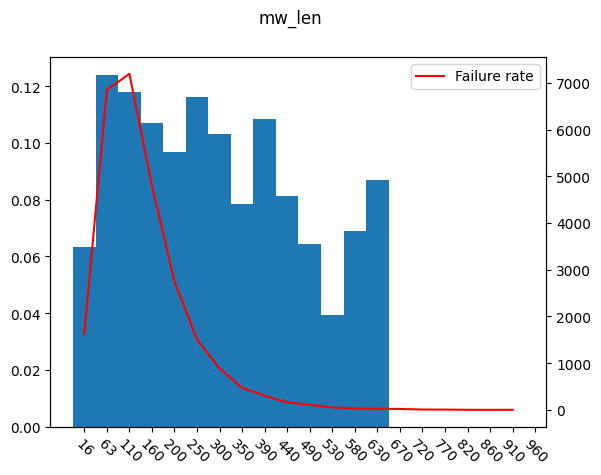

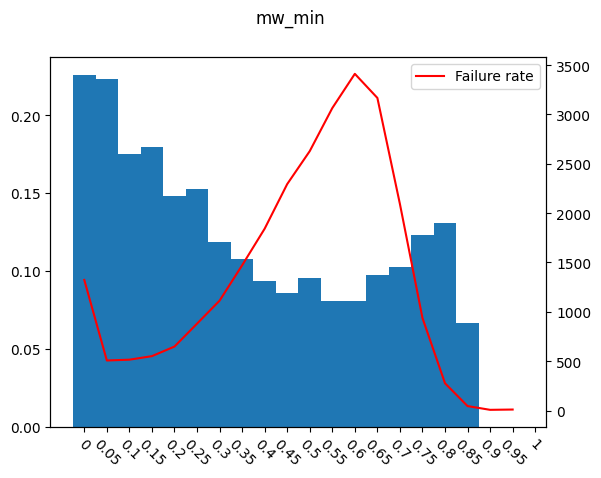

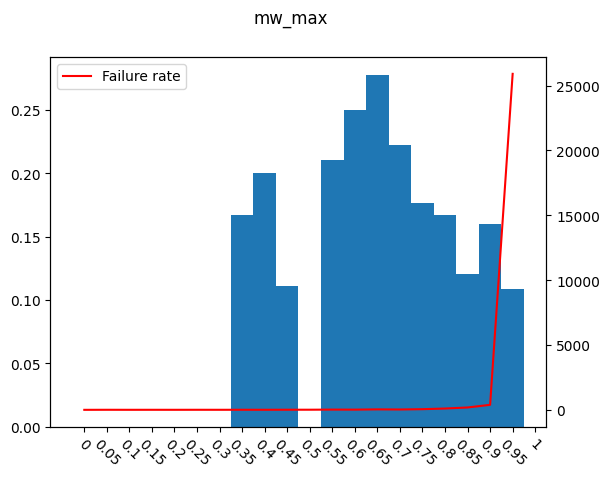

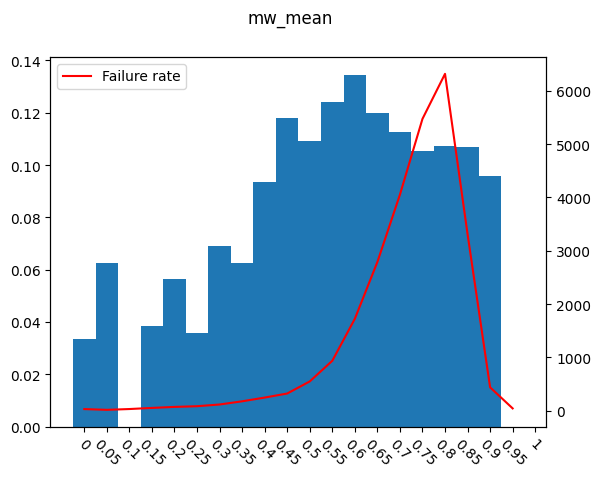

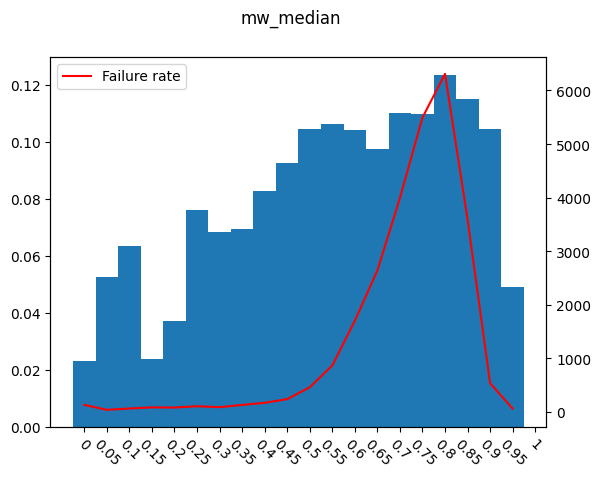

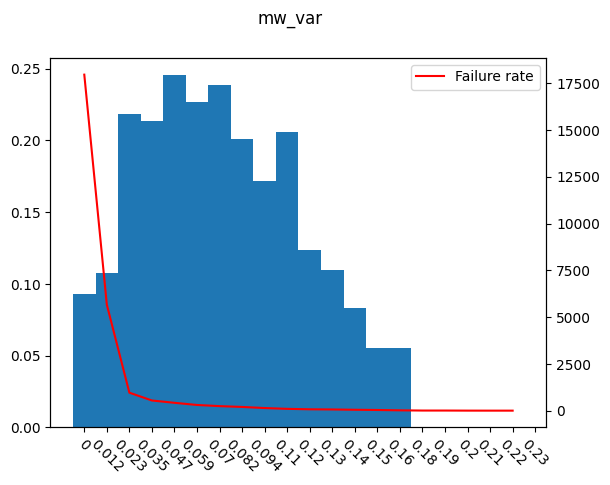

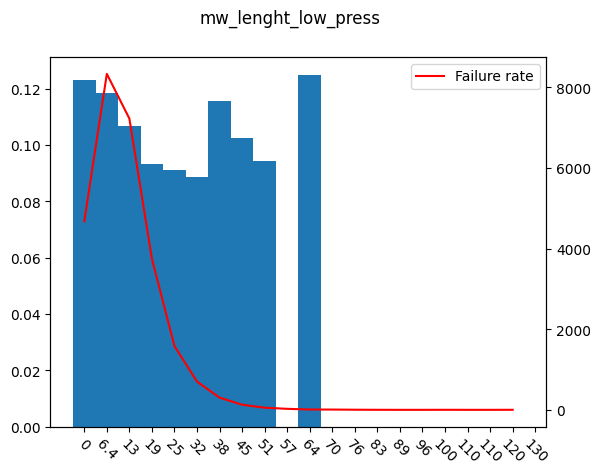

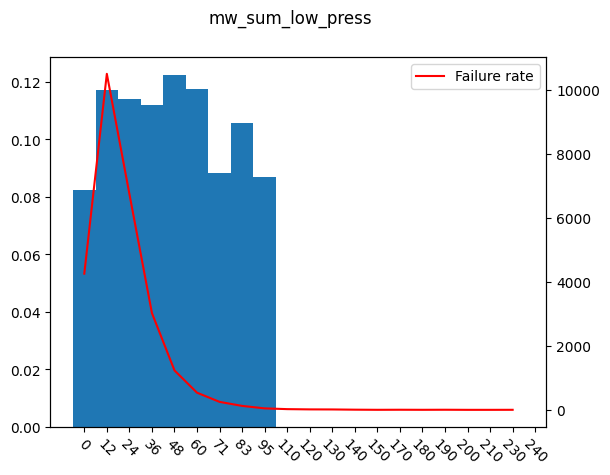

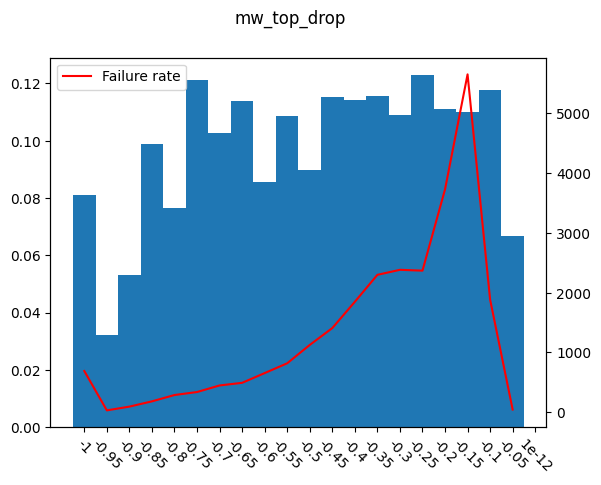

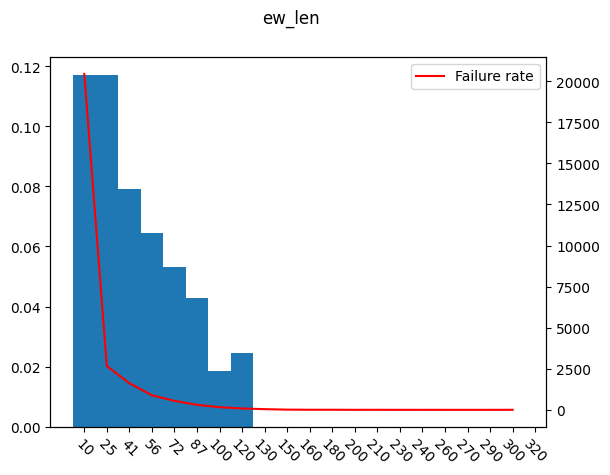

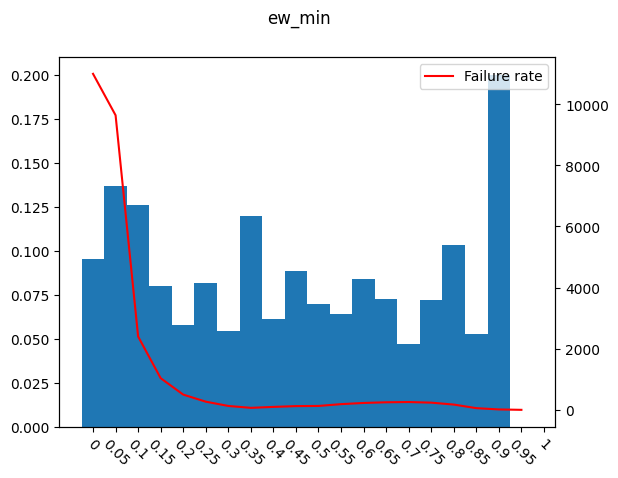

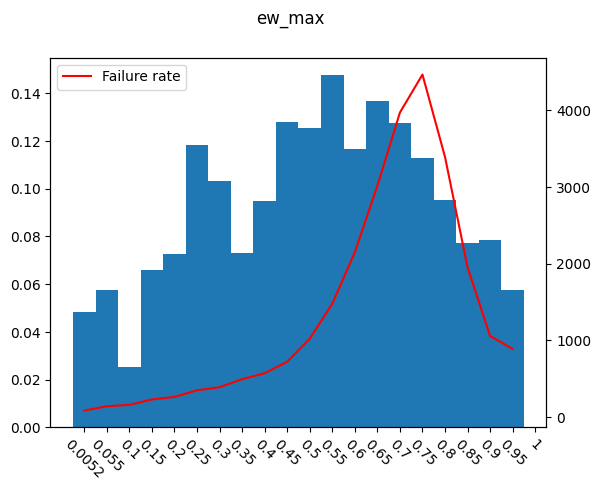

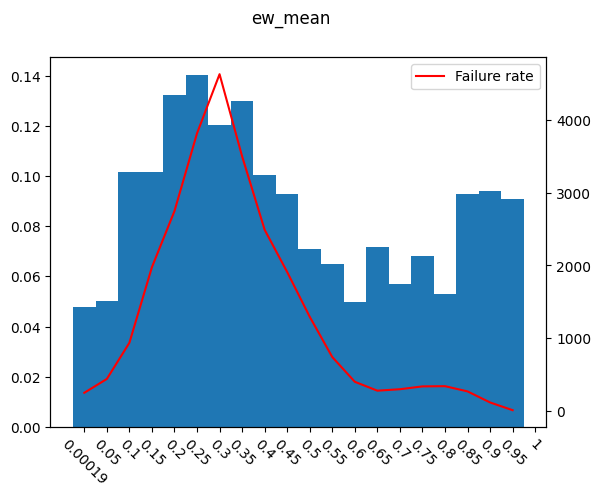

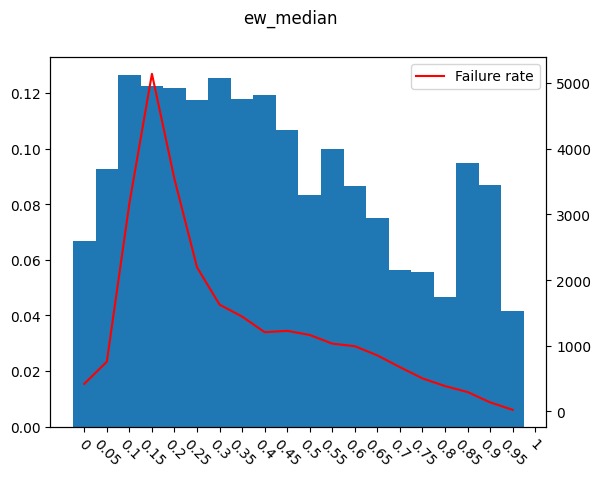

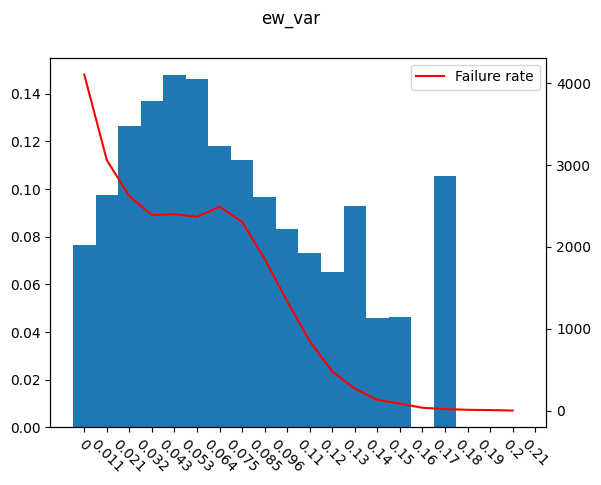

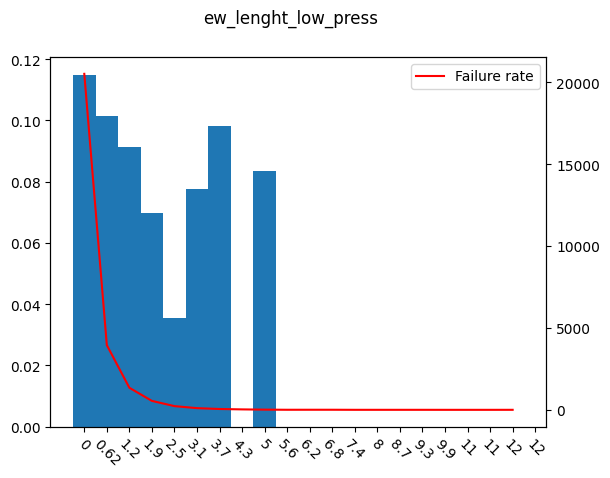

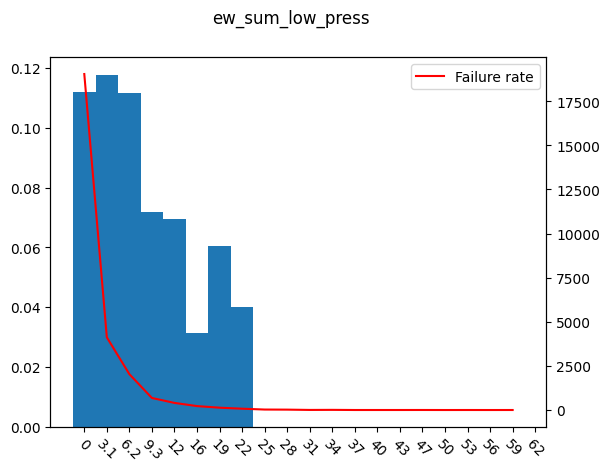

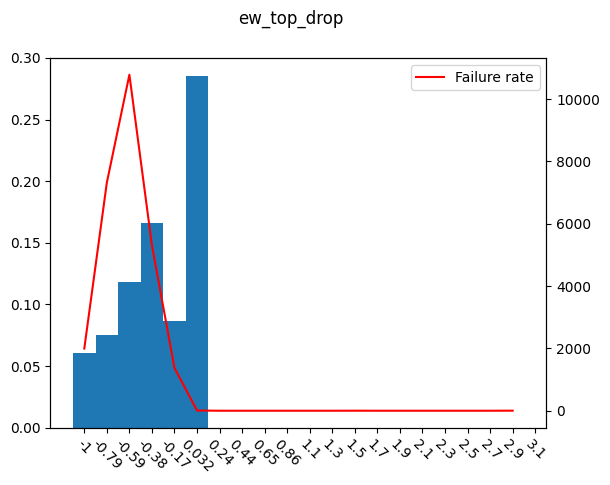

In [ ]:
#Univariate analysis
for id, column in enumerate(new_features.columns):
    var = dev_sample[column]
    n_bins = 20
    bins = np.linspace(var.min(), var.max() + 1e-12, n_bins+1) # 10 bins, so 11 bin boundaries
    c = np.digitize(var, bins)
    label_bins = ['{:g}'.format(float('{:.2g}'.format(i))) for i in bins]
    fig, ax1 = plt.subplots()
    fig.suptitle(column)
    ax2 = ax1.twinx()
    ax1.bar(bins[:-1], [dev_sample[c == i]['Failed'].mean() for i in range(1, len(bins))],
            width=bins[1] - bins[0] )
    ax2.plot(bins[:-1], [dev_sample[c == i]['Failed'].count() for i in range(1, len(bins))],color='red',label='Failure rate')
    ax2.legend()
    ax1.set_xticks(bins,labels=label_bins,rotation=-45)
    plt.show()






#Moddeling

In [ ]:
#I am short on time, so the moddeling will be just very quick, just schoolbook aplication of xgboost
#I choose xgboost because it usually give best performance without parameter finetuning and the dataset is large enough
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import f1_score

In [ ]:
vars = [item for item in dev_sample.columns if item not in labelsD.columns]
print(vars)


['sw_len', 'sw_min', 'sw_max', 'sw_mean', 'sw_median', 'sw_var', 'sw_lenght_low_press', 'sw_sum_low_press', 'sw_top_drop', 'mw_len', 'mw_min', 'mw_max', 'mw_mean', 'mw_median', 'mw_var', 'mw_lenght_low_press', 'mw_sum_low_press', 'mw_top_drop', 'ew_len', 'ew_min', 'ew_max', 'ew_mean', 'ew_median', 'ew_var', 'ew_lenght_low_press', 'ew_sum_low_press', 'ew_top_drop', 'orig_lenght', 'new_lenght', 'first_nonzero_index', 'last_nonzero_index', 'max_press', 'median_press']


In [ ]:
X = dev_sample[vars]
y = dev_sample['Failed']

In [ ]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = RANDOM_STATE)

In [ ]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)
y_proba = regressor.predict(X_test)
y_pred = [round(value) for value in y_proba]

In [ ]:
print('roc_auc_score:',roc_auc_score(y_test, y_proba))

roc_auc_score: 0.8911530480569706


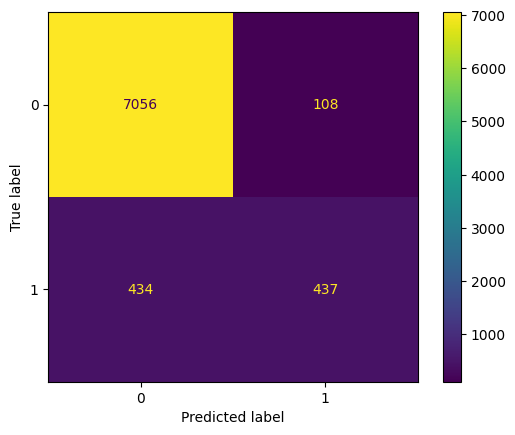

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

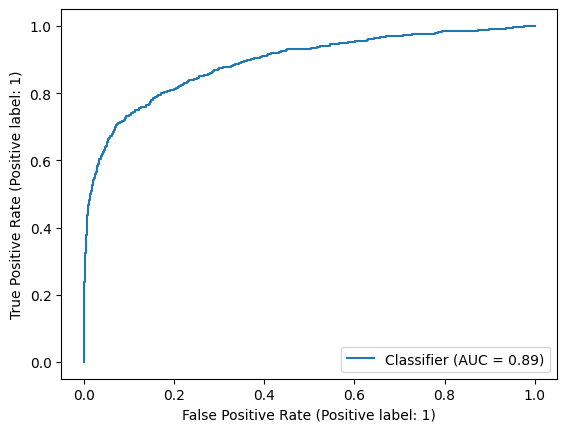

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba)

In [ ]:
pd.DataFrame(regressor.feature_importances_, index=vars).sort_values(by=0,ascending=False).head(10)

NameError: ignored

In [ ]:
#unfotunatelly, I am out of 1 manday donation
#save the data
dev_sample.to_parquet(DATA_PATH+'dev_sample.parquet')
labelsD.to_parquet(DATA_PATH+'labelsD.parquet')
